<a href="https://colab.research.google.com/github/yonghanchoi/DataAnalysis/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (25.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126718 files and direc

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [4]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content) ##
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)##
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')##
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [6]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [5]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [7]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)#int는 경량화
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [8]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의(위 그림임)
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의(책에 있는 고양이는 빼고 계산)
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [10]:
set_seed(86)#원래 42였는데 답이 틀려서 바꿨더니 정답
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청(답이 틀릴 수도)
question = 'how many cats in the photo? including the books cover.'##
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [11]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [12]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'##
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

No.
Yes.
Yes, this image is of clothing. Specifically, it features a pair of boots, which are a type of footwear. The focus on the craftsmanship and design elements such as the stitching and material suggests that these boots could be considered part of a fashion item or outdoor gear, depending on their intended use.
Yes, this image appears to be a display of clothing. The man is wearing a sweater, shorts, and a hat, which are the main subjects of the photograph. The focus on his attire suggests that it could be used for fashion-related purposes such as an advertisement or a catalog showcasing these items.
Yes.
Yes.
No.
No, this image is not of clothing. It is a book cover featuring a photograph and text related to the work of Joel Meyerowitz, an American photographer known for his street photography. The content on the cover suggests that it contains photographs spanning from 1962 to 2022, indicating a retrospective collection or exhibition catalog.
No.
Yes, this image is of clothing.

## 14-6 의류 판단 결과 시각화

In [13]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,False
1,,True
2,,True
3,,True
4,,True
5,,True
6,,False
7,,False
8,,False
9,,True


## 14-7 의류 이미지 필터링

In [14]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]##

In [15]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
1,,True
2,,True
3,,True
4,,True
5,,True
9,,True
10,,True


## 14-8 의류 스타일 분석

In [16]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style df the clothes. Please let me exlpain the colors and trend changes.' ##
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-2723016381.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [17]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
1,,True,"The style of the clothing in the image suggests a casual and somewhat traditional aesthetic. The sweater features a color palette that includes earthy tones such as beige, dark green, and black. These colors are often associated with natural materials and can be found in garments designed for cooler weather, indicating functionality as well as fashion.\n\nThe pattern on the sweater is reminiscent of traditional Scandinavian or Nordic designs, which typically incorporate geometric shapes and motifs inspired by nature. This kind of design has seen a resurgence in popularity, particularly in recent years, where there's been an appreciation for heritage patterns and sustainable practices.\n\nIn terms of trend changes, this style of sweater could be considered part of a broader movement towards more eco-friendly and locally-inspired fashion choices. It reflects a shift away from fast fashion to pieces that are not only stylish but also made with consideration for the environment and cultural heritage. The choice of such a sweater might indicate a preference for timeless styles over fleeting trends, suggesting a personal taste that values quality and tradition."
2,,True,"The boots in the image are styled with a classic and rugged aesthetic, often associated with workwear or outdoor activities. The dark brown color is versatile and timeless, commonly used in footwear for its durability and ability to match various outfits. The stitching around the toe cap and along the seams adds a distinctive detail that not only serves as reinforcement but also enhances the visual interest of the boot.\n\nIn terms of fashion trends, such boots have experienced several waves of popularity over the years. They were particularly popular during the 1970s and early 2000s, seen as a staple item in casual and country-inspired wardrobes. In recent times, there has been a resurgence in the appeal of these types of shoes due to their comfort, craftsmanship, and the nostalgic appeal they carry. The design reflects a blend of practicality and style, making them suitable for both everyday wear and more specialized uses like hiking or farming.\n\nThe trend changes observed include an increased focus on sustainability and ethically sourced materials in contemporary footwear, which may influence how these boots are perceived and marketed today. Additionally, there's a growing preference for vintage and retro styles, which could explain why this particular boot design remains relevant despite being rooted in earlier fashion eras."
3,,True,"The style of the clothing in the image leans towards a casual, possibly vintage-inspired look. The beige sweater with its textured knit pattern suggests a preference for comfort and warmth, which is often seen in casual or outdoor wear. The use of neutral colors like beige and navy blue indicates a minimalist approach to fashion, where simplicity and understated elegance are key.\n\nThe bucket hat adds an element of practicality and can be associated with styles that favor utility alongside aesthetics. Hats like this one have been popular in various fashion eras, from the 1950s to more recent times, often making a comeback as part of a retro revival trend.\n\nThe layered look with a turtleneck under the sweater is another indicator of a laid-back yet thoughtful approach to dressing. Layering is a versatile technique that allows for adjustments based on temperature changes throughout the day.\n\nOverall, the outfit could be categorized within contemporary casual fashion trends that incorporate elements of past decades' styles, such as the relaxed silhouette of shorts paired with a cozy sweater and a classic bucket hat. This combination reflects a blend of functionality and style that has enduring appeal."
4,,True,"The clothing style in the image leans towards a casual and somewhat streetwear-inspired aesthetic. The dark brown jacket has a high collar, which adds to its functionality and contempora

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [19]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정 시간 많이 걸림
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 10-26 06:13:55 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 10-26 06:13:56 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 10-26 06:14:19 config.py:549] This model supports multiple tasks: {'reward', 'generate', 'embed', 'score', 'classify'}. Defaulting to 'generate'.
INFO 10-26 06:14:19 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 10-26 06:14:22 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 10-26 06:14:22 cuda.py:226] Using XFormers backend.
INFO 10-26 06:14:23 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 10-26 06:14:23 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 10-26 06:17:45 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 201.384532 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-26 06:18:37 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 10-26 06:18:41 worker.py:267] Memory profiling takes 2.62 seconds
INFO 10-26 06:18:41 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 10-26 06:18:41 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 10-26 06:18:41 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 10-26 06:18:41 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 10-26 06:18:46 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]

INFO 10-26 06:19:33 model_runner.py:1562] Graph capturing finished in 47 secs, took 0.21 GiB
INFO 10-26 06:19:33 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 56.08 seconds


## 14-10 색상 정보 추출

In [20]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 10-26 06:19:40 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, est. speed input: 423.26 toks/s, output: 25.27 toks/s]


**색상:**
- 베이지
- 어두운 초록색
- 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, est. speed input: 1053.68 toks/s, output: 30.10 toks/s]


**색상:**
- 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, est. speed input: 638.93 toks/s, output: 34.65 toks/s]


- 베이지 (Beige)
- 네이비 블루 (Navy Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s, est. speed input: 1071.01 toks/s, output: 27.76 toks/s]


색상:
- 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, est. speed input: 389.53 toks/s, output: 37.38 toks/s]


- 올리브 그린 (Olive Green)
- 갈색 (Brown)
- 밝은 파란색 (Light Blue)
- 검정색 (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, est. speed input: 357.75 toks/s, output: 36.73 toks/s]


**색상:**
- **노란색** (pale yellow shirt)
- **파란색** (light blue denim shorts)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, est. speed input: 604.98 toks/s, output: 35.07 toks/s]

- 올리브 그린 (Olive Green)
- rust (Rust)



/tmp/ipython-input-537633341.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, est. speed input: 720.73 toks/s, output: 26.89 toks/s]


- beige
- dark green
- black


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, est. speed input: 1193.76 toks/s, output: 26.53 toks/s]


**색상:** 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, est. speed input: 574.18 toks/s, output: 31.14 toks/s]


- 베이지 (Beige)
- 네이비 블루 (Navy Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, est. speed input: 1010.63 toks/s, output: 26.20 toks/s]


색상:
- 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, est. speed input: 408.96 toks/s, output: 36.72 toks/s]


- 올리브 그린 (Olive Green)
- 갈색 (Brown)
- 하늘색 (Light Blue)
- 검정색 (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, est. speed input: 480.88 toks/s, output: 34.74 toks/s]


- **노란색** (Pale Yellow)
- **파란색** (Light Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, est. speed input: 437.48 toks/s, output: 33.29 toks/s]

- 올리브 그린 (Olive Green)
- 주황빛 빨강 (Rust-colored)



/tmp/ipython-input-1495174350.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_color)


In [22]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
1,,True,"The style of the clothing in the image suggests a casual and somewhat traditional aesthetic. The sweater features a color palette that includes earthy tones such as beige, dark green, and black. These colors are often associated with natural materials and can be found in garments designed for cooler weather, indicating functionality as well as fashion.\n\nThe pattern on the sweater is reminiscent of traditional Scandinavian or Nordic designs, which typically incorporate geometric shapes and motifs inspired by nature. This kind of design has seen a resurgence in popularity, particularly in recent years, where there's been an appreciation for heritage patterns and sustainable practices.\n\nIn terms of trend changes, this style of sweater could be considered part of a broader movement towards more eco-friendly and locally-inspired fashion choices. It reflects a shift away from fast fashion to pieces that are not only stylish but also made with consideration for the environment and cultural heritage. The choice of such a sweater might indicate a preference for timeless styles over fleeting trends, suggesting a personal taste that values quality and tradition.",**색상:**\n- 베이지\n- 어두운 초록색\n- 검정색,- beige\n- dark green\n- black
2,,True,"The boots in the image are styled with a classic and rugged aesthetic, often associated with workwear or outdoor activities. The dark brown color is versatile and timeless, commonly used in footwear for its durability and ability to match various outfits. The stitching around the toe cap and along the seams adds a distinctive detail that not only serves as reinforcement but also enhances the visual interest of the boot.\n\nIn terms of fashion trends, such boots have experienced several waves of popularity over the years. They were particularly popular during the 1970s and early 2000s, seen as a staple item in casual and country-inspired wardrobes. In recent times, there has been a resurgence in the appeal of these types of shoes due to their comfort, craftsmanship, and the nostalgic appeal they carry. The design reflects a blend of practicality and style, making them suitable for both everyday wear and more specialized uses like hiking or farming.\n\nThe trend changes observed include an increased focus on sustainability and ethically sourced materials in contemporary footwear, which may influence how these boots are perceived and marketed today. Additionally, there's a growing preference for vintage and retro styles, which could explain why this particular boot design remains relevant despite being rooted in earlier fashion eras.",**색상:**\n- 어두운 갈색,**색상:** 어두운 갈색
3,,True,"The style of the clothing in the image leans towards a casual, possibly vintage-inspired look. The beige sweater with its textured knit pattern suggests a preference for comfort and warmth, which is often seen in casual or outdoor wear. The use of neutral colors like beige and navy blue indicates a minimalist approach to fashion, where simplicity and understated elegance are key.\n\nThe bucket hat adds an element of practicality and can be associated with styles that favor utility alongside aesthetics. Hats like this one have been popular in various fashion eras, from the 1950s to more recent times, often making a comeback as part of a retro revival trend.\n\nThe layered look with a turtleneck under the sweater is another indicator of a laid-back yet thoughtful approach to dressing. Layering is a versatile technique that allows for adjustments based on temperature changes throughout the day.\n\nOverall, the outfit could be categorized within contemporary casual fashion trends that incorporate elements of past decades' styles, such as the relaxed silhouette of shorts paired with a cozy sweater and a classic bucket hat. This combination reflects a blend of functionality and style that has enduring appeal.",- 베이지 (Beige)\n- 네이비 블루 (Navy Blue),- 베이지 (Beige)\n- 네이비 블루 (Navy Blue)
4,,True,"The

## 14-12 텍스트 데이터 정제

In [23]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2959970496.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2959970496.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

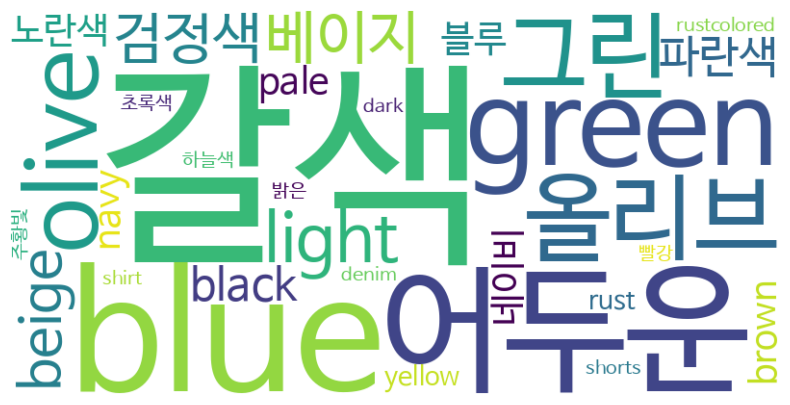

In [24]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [27]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트:{row.style}\n 이미지 url:{row.image}"})##
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석보고서를 작성해주세요. 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서는 markdown으로 만들어 주세요."})##

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.05s/it, est. speed input: 109.92 toks/s, output: 38.65 toks/s]


In [28]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 트렌드를 분석하고, 그 특징과 미래 전망을 종합적으로 제시합니다. 주요 분석 대상은 다양한 색상 팔레트, 기능성과 스타일의 융합, 그리고 지속 가능성에 대한 관심입니다.

## 트렌드 분석

### 1. **실용성과 스타일의 융합**
- **색상 팔레트**:
  - ** earthy tones (베이지, 다크 그린, 블랙, 올리브 그린 등)**: 자연 친화적이고 기능적인 이미지를 전달하며, 최근 트렌드에서 지속 가능성과 환경 친화적인 소재 사용에 대한 관심을 반영합니다.
  - ** 중성적 톤 (베이지, 네이비)**: 미니멀리즘과 고급스러움을 동시에 추구하는 현대적인 스타일을 나타냅니다.
  - ** 밝고 부드러운 톤 (옐로우, 블루)**: 캐주얼하면서도 세련된 느낌을 주며, 특히 스트리트웨어에서 많이 활용됩니다.

- **디자인 요소**:
  - **전통적 패턴과 현대적 재해석**: 전통적인 북유럽 패턴이나 빈티지 스타일의 재해석이 최근 트렌드에서 중요한 위치를 차지하고 있습니다.
  - **기능성과 패션의 결합**: 실용적인 디자인 요소 (예: 큰 포켓, 편안한 핏의 재킷)가 패션 아이템에 통합되어 기능성과 스타일을 동시에 제공합니다.

### 2. **지속 가능성과 윤리적 패션**
- **친환경 소재**: 최근 트렌드는 재활용 소재와 유기농 섬유의 사용을 강조하며, 이러한 소재는 환경 친화적인 이미지를 강화합니다.
- **지역적 영감**: 현지 문화와 전통을 반영한 디자인이 주목받고 있으며, 이는 지속 가능한 패션의 한 형태로 해석됩니다.

### 3. **스트리트웨어와 캐주얼 패션의 융합**
- **실용적이고 편안한 스타일**: 스트리트웨어의 기능성과 캐주얼 패션의 편안함이 결합되어 일상적인 활동과 특별한 순간 모두에 적합한 룩을 제공합니다.
- **레이어링 기법**: 여러 층을 활용한 디자인은 개인의 스타일을 더욱 돋보이게 하며, 다양한 상황에 유연하게 대응할 수 있는 능력을 강조합니다.

## 미래 전망
- **지속 가능성 강화**: 환경 친화적인 소재와 생산 방식에 대한 관심이 더욱 증가할 것으로 예상되며, 이는 패션 산업의 핵심 트렌드가 될 것입니다.
- **문화적 다양성의 확장**: 다양한 문화적 영감을 반영한 디자인이 더욱 주목받을 것으로 보입니다. 특히, 지역적 특성과 전통 패턴의 현대적 해석이 주목받을 것입니다.
- **개인화와 맞춤형 패션**: 개인의 취향과 활동 패턴에 맞춘 맞춤형 패션 아이템의 수요가 증가할 것으로 예상됩니다. 이는 디지털 기술과 결합하여 더욱 발전할 것입니다.

## 결론
최근 해외 패션 룩북에서 관찰되는 트렌드는 실용성과 스타일의 균형, 지속 가능성에 대한 인식의 강화, 그리고 스트리트웨어와 캐주얼 패션의 융합을 중심으로 형성되고 있습니다. 이러한 경향은 미래 패션 산업에서 더욱 다양성과 개인화를 추구하는 방향으로 나아갈 것으로 전망됩니다.

---

이 보고서는 패션 트렌드의 현재 상태와 미래 전망을 종합적으로 분석하여 제공하였습니다. 각 룩북에서 관찰된 특징들이 어떻게 패션 산업 전반에 걸쳐 적용되고 발전할 수 있는지에 대한 통찰을 제공합니다.